In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [3]:
df = pd.read_csv("/kaggle/input/housing-hw6/housing.csv")
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df = df.fillna(0)
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [14]:
y_val_orig, y_val

(array([178300., 187500.,  96600., ..., 301600.,  62100., 114900.]),
 array([12.09122841, 12.14153946, 11.47834437, ..., 12.61686023,
        11.03651737, 11.65182617]))

In [6]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
dir(dv)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_iterable_element',
 '_check_feature_names',
 '_check_n_features',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_transform',
 '_validate_data',
 '_validate_params',
 'dtype',
 'feature_names_',
 'fit',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'inverse_transform',
 'restrict',
 'separator',
 'set_output',
 'set_params',
 'sort',
 'sparse',
 'transform',
 'vocabulary_']

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [13]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.feature_names_))


|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [16]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [17]:
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)


0.24495290030597153

In [19]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

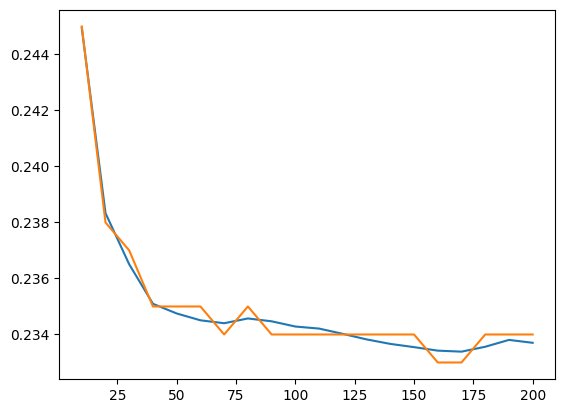

In [21]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

In [22]:
from tqdm.auto import tqdm

In [23]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

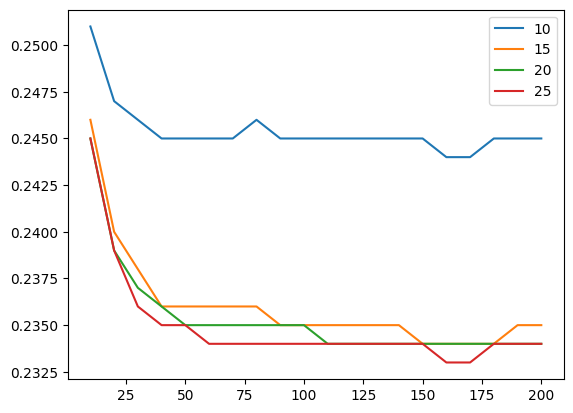

In [24]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse.round(3), label=d)

plt.legend()
plt.show()

In [25]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806


In [27]:
import xgboost as xgb


In [29]:
features = dv.feature_names_
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [33]:
features = [f.replace('<', 'less ') for f in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=less 1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [35]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}


def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [36]:
%%capture output_03

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [37]:
scores['eta=0.3'] = parse_xgb_output(output_03)


In [38]:
%%capture output_01

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [39]:
scores['eta=0.1'] = parse_xgb_output(output_01)

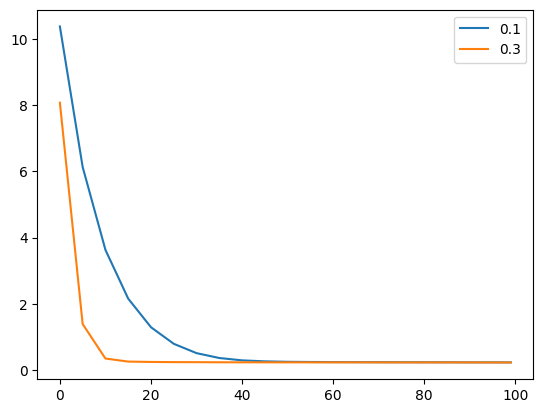

In [40]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc.round(3),
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc.round(3),
        label='0.3')
plt.legend()
plt.show()